# MWL's attempt to use redrock version 0.8.1, and minor fixes
## Kludges put to some redrock modules to make syntax consistent

In [1]:
import pdb
import numpy as np
import matplotlib.pyplot as plt
import redrock.targets as tgs
import astropy.units as u
import redrock.templates as rrtpl
from linetools.spectra.xspectrum1d import XSpectrum1D
from elg_cgm import elgUtils as elg
from linetools.spectra.utils import rebin
from astropy.io import fits
from astropy.table import Table
from desisim.pixelsplines import gauss_blur_matrix as gbm

## J2223+0137

### Rebinning and creating redrock object

In [54]:
# Read file
specFile = '../Redux/2017Jul14/Science/J2223+0137.hdf5'
specTable = Table.read(specFile)

#Get the coadded spectrum
galFlux = specTable['flux'][0]  ## Greg: Why divide flux by u.AA?
galSig = specTable['sig'][0]  ## Greg: I suspect the error array is 1-sigma, not variance
galWav = specTable['wave'][0]

np.where(galSig <= 0.)[0]

array([   0,  518,  519, 2112, 2113, 2114, 2115, 2116, 2117, 2118, 2119,
       2120, 2121, 2122, 2123, 2124, 2125, 2126, 2127, 2128, 2129, 2130,
       2131, 2132, 2133, 2134, 2135, 2136, 2137, 2138, 2139, 2140, 2141,
       2142, 2143, 2144, 2145, 2146, 2147, 2148, 2149, 2150, 2151, 2152,
       2153, 2154, 2155, 2156, 2157, 2158, 2159, 2160, 2161, 2162, 2163,
       2164, 2697, 2698, 2724])

In [56]:
gd = range(520,2112)
galFlux_cut = galFlux[gd]
galSig_cut = galSig[gd]
galWav_cut = galWav[gd]

#Restrict to a well-fluxed wavelength range
gd = np.where(galWav_cut <= 7000.)[0]
galFlux_cut = galFlux_cut[gd]
galSig_cut = galSig_cut[gd]
galWav_cut = galWav_cut[gd]

#Create Xspectrum1D object
spec = XSpectrum1D.from_tuple((galWav_cut,galFlux_cut,galSig_cut),verbose=False)

#Rebin to constant velocity bins
newSpec = elg.rebin2ConstVel(spec,do_sig=True,grow_bad_sig=True)

#Create resolution matrix  
pixbound = np.append(newSpec.wavelength.value,spec.wvmax.value)
sig_conv = newSpec.sig.value
R = gbm(pixbound,sig_conv)

# Create redrock spectrum object and target object
rrSpecObj = tgs.Spectrum(newSpec.wavelength.value,newSpec.flux.value,1/newSpec.sig.value**2,
                         R.todia(),R)
rrTargObj = tgs.Target('J2223+0137',[rrSpecObj])

#Get galaxy template
galTemp = rrtpl.Template(filename=rrtpl.find_templates()[0])

DEBUG: Using default redshift range 0.0050-1.6988 for rrtemplate-galaxy.fits


### Finding redshifts

In [57]:
galTemp._redshifts = np.linspace(start=0.3,stop=0.5,num=1000)

In [58]:
from redrock.zfind import zfind
distTarg = tgs.DistTargetsCopy([rrTargObj])
dwave = distTarg.wavegrids()
distTemp = rrtpl.DistTemplate(galTemp,dwave)
zscan,zfit = zfind(distTarg,[distTemp])

Computing redshifts
  Scanning redshifts for template GALAXY
    Progress:   0 %
    Progress:  10 %
    Finished in: 0.5 seconds
  Finding best fits for template GALAXY
    Finished in: 0.2 seconds


In [59]:
zfit

chi2,coeff [10],z,zerr,zwarn,zz [15],zzchi2 [15],npixels,spectype,subtype,ncoeff,targetid,znum,deltachi2
float64,float64,float64,float64,int64,float64,float64,int64,str6,str1,int64,str10,int64,float64
1757.59870252,199.514802151 .. -42.4816546759,0.369923407226,0.000127480814484,0,0.36966966967 .. 0.37007007007,1762.1836676 .. 1758.63854293,1275,GALAXY,,10,J2223+0137,0,111.526558552
1869.12526107,-2799.31050742 .. -222.895618824,0.34021398197,3.98209253866e-05,0,0.34004004004 .. 0.34044044044,1879.40595316 .. 1917.08619358,1275,GALAXY,,10,J2223+0137,1,26.7553622276
1895.8806233,-5635.00883818 .. 134.110957491,0.300322410499,3.12003958941e-05,0,0.3002002002 .. 0.300600600601,1910.23381853 .. 1911.34197083,1275,GALAXY,,10,J2223+0137,2,0.0


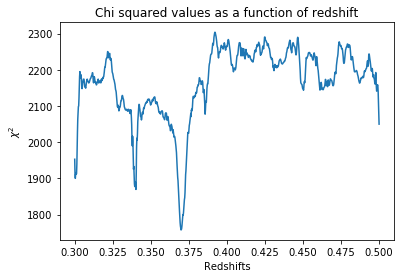

In [60]:
%matplotlib inline
plt.plot(zscan['J2223+0137']['GALAXY']['redshifts'],zscan['J2223+0137']['GALAXY']['zchi2'])
plt.xlabel('Redshifts')
plt.ylabel('$\chi^2$')
plt.title('Chi squared values as a function of redshift')

<IPython.core.display.Javascript object>


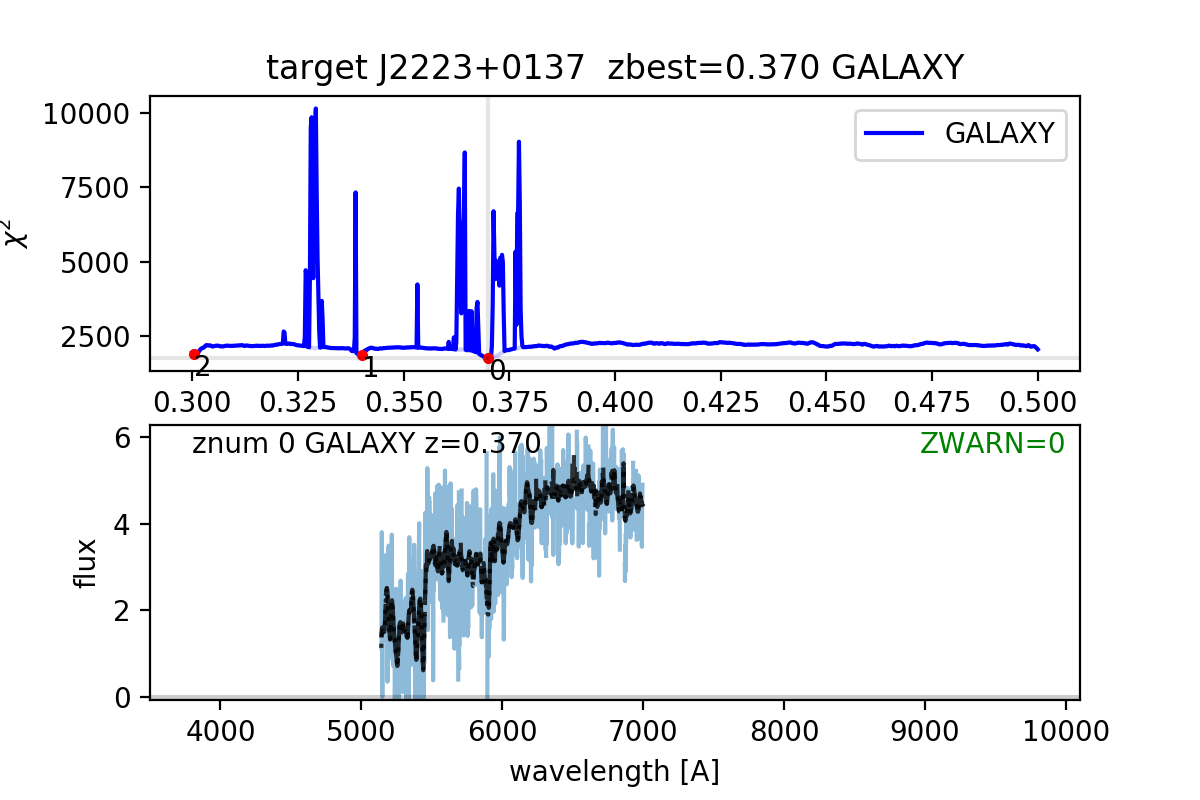

-------------------------------------------------------------------------
Select window then use keyboard shortcuts to navigate:
    up/down arrow: previous/next target
    left/right arrow: previous/next redshift fit for this target
    (d)etails
-------------------------------------------------------------------------
target 0 id J2223+0137 znum 0 GALAXY z=0.370


In [61]:
%matplotlib notebook
from redrock.plotspec import PlotSpec as ps
intPlots = ps([rrTargObj],[galTemp],zscan,zfit)